In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import os

# Suppress all warnings
import warnings
warnings.filterwarnings("ignore")

%matplotlib widget


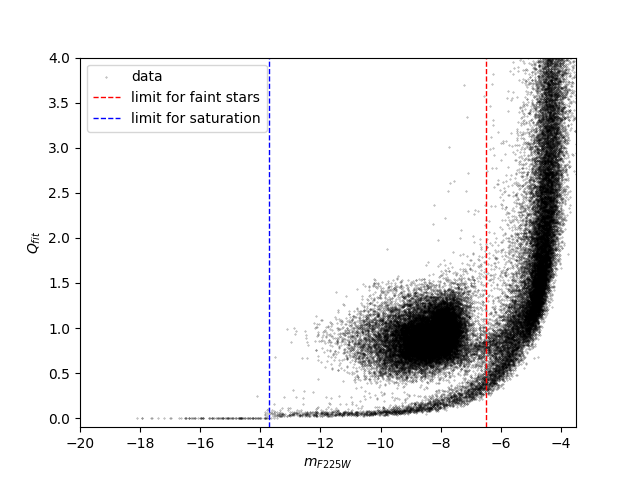

In [2]:
input_file = '/Users/giadaaggio/Desktop/Thesis/TOTORO/FITS/F225W/if1h04cpq_WJC.xym'
data = pd.read_csv(input_file, comment='#', delim_whitespace=True, header=None, names=['x', 'y', 'magnitude', 'qfit', 'nan'])

filter_used = 'F225W'

data['qfit'] = data['qfit'].astype(str)
filtered_data = data[data['qfit'] != "*********"]
filtered_data['qfit'] = pd.to_numeric(filtered_data['qfit'], errors='coerce')
# Filter rows where 'qfit' is between 0 and 1 (inclusive)
qfit_range_data = filtered_data[(filtered_data['qfit'] >= 0)] #& (filtered_data['qfit'] <= 1)]


# Check if the necessary columns are present
if 'magnitude' not in data.columns or 'qfit' not in data.columns:
    print("The input data must contain 'magnitude' and 'qfit' columns.")

saturation_limit  = - 13.7
faint_limit = - 6.5

# Create the plot
plt.figure()
plt.scatter(qfit_range_data['magnitude'], qfit_range_data['qfit'], color='black', alpha=0.5, s=0.1, label='data')

# plot a vertical line at x = - 6.5 (limit for faint stars)
plt.axvline(x=faint_limit, color='red', linestyle='--', linewidth = 1, label='limit for faint stars')

# plot a vertical line at x = - 13.7 (limit for saturation)
plt.axvline(x=saturation_limit, color='blue', linestyle='--', linewidth = 1, label='limit for saturation')

plt.xlabel(r'$m_{F225W}$')
plt.ylabel(r'$Q_{fit}$')
plt.legend()
plt.ylim(-0.1, 4)
plt.xlim(-20, -3.5)
plt.show()


### Median and standard deviation

In [3]:
# Define the range we are working with (the critical range, after i will concantenate the selected data with the ones outside the range)
qfit_range_data_crit = qfit_range_data[(qfit_range_data['magnitude'] >= saturation_limit) & (qfit_range_data['magnitude'] <= faint_limit)]

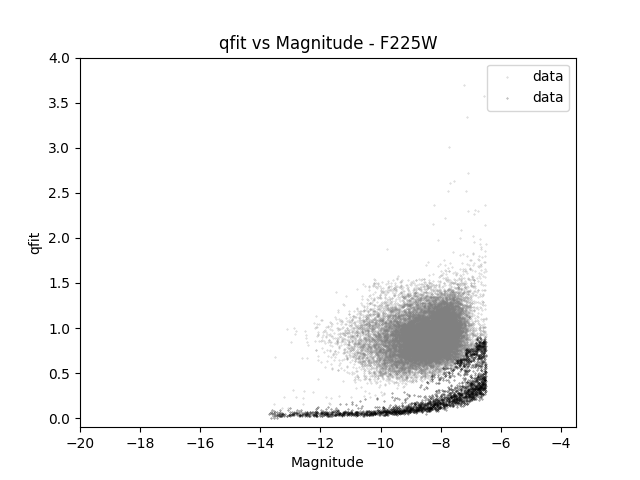

In [4]:
# Define magnitude range and number of zones
magnitude_min = saturation_limit  # start of the range
magnitude_max = faint_limit   # end of the range (faint star limit)
n_zones = 15  # number of zones

# Define qfit upper limit range
qfit_min = 0.1  # starting upper limit for qfit
qfit_max = 0.9  # ending upper limit for qfit

# Calculate magnitude boundaries and qfit upper limits for each zone
magnitude_limits = np.geomspace(magnitude_min, magnitude_max, n_zones + 1)
qfit_limits = np.geomspace(qfit_min, qfit_max, n_zones)

# Initialize list to store data for each zone
zone_data = []

# Iterate over the zones and filter the data
for i in range(n_zones):
    lower_mag_limit = magnitude_limits[i]
    upper_mag_limit = magnitude_limits[i + 1]
    qfit_limit = qfit_limits[i]
    
    # Select data for the current zone
    zone = qfit_range_data_crit[(qfit_range_data_crit['magnitude'] > lower_mag_limit) & 
                         (qfit_range_data_crit['magnitude'] <= upper_mag_limit) & 
                         (qfit_range_data_crit['qfit'] <= qfit_limit)]
    
    # Append the filtered zone data to the list
    zone_data.append(zone)

# Concatenate the data for all zones
filtered_data = pd.concat(zone_data)

plt.figure()
plt.scatter(qfit_range_data_crit['magnitude'], qfit_range_data_crit['qfit'], color='grey', alpha=0.5, s=0.1, label='data')
plt.scatter(filtered_data['magnitude'], filtered_data['qfit'], color='black', alpha=0.5, s=0.1, label='data')
plt.xlabel('Magnitude')
plt.ylabel('qfit')
plt.legend()
plt.ylim(-0.1, 4)
plt.xlim(-20, -3.5)
plt.title(f'qfit vs Magnitude - {filter_used}')
plt.show()




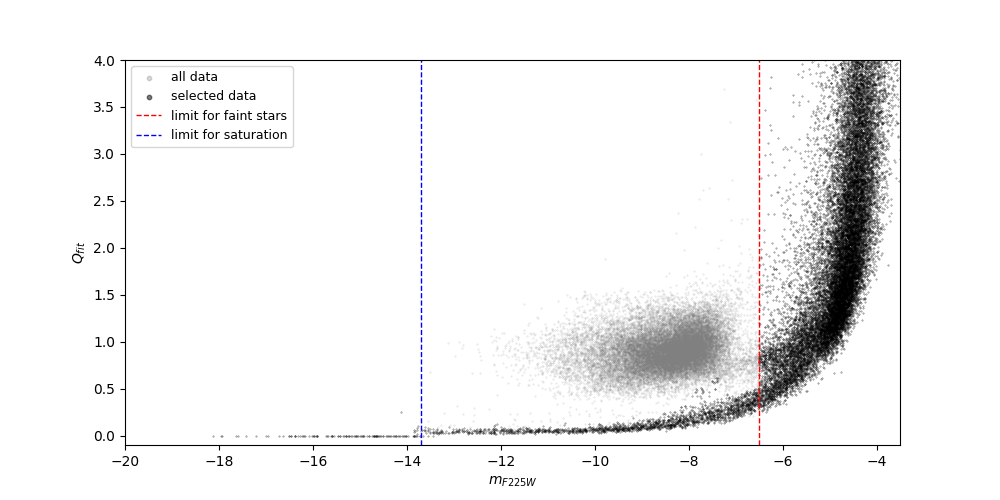

In [5]:
'''''
I have to select only the good data, the one that do not belong to the cloud of points. 
I have to consider as good data even all the ones that are saturated or too faint (qfit is not a good parameter for these cases).
A method to do so would consist in plotting a curve that divide the good data from the bad ones and then select the data that are below the curve.
'''''
# Define the number of bins
n_bins = 100

# Create the bins
bins = np.linspace(saturation_limit, faint_limit, n_bins)

# Calculate the median and standard deviation of the qfit values for each bin
medians = []
stds = []
for i in range(len(bins) - 1):
    bin_data = filtered_data[(filtered_data['magnitude'] >= bins[i]) & (filtered_data['magnitude'] < bins[i + 1])]
    median = bin_data['qfit'].median()
    std = bin_data['qfit'].std()
    if median >= 0.3:
        bin_data_outlier = bin_data[bin_data['qfit'] < 0.5]
        median = bin_data_outlier['qfit'].median()
        std = bin_data_outlier['qfit'].std()
    medians.append(median)
    stds.append(std)

# Remove the points that are outside the range median +- 3*std
good_data = pd.DataFrame()
for i in range(len(bins) - 1):
    bin_data = filtered_data[(filtered_data['magnitude'] >= bins[i]) & (filtered_data['magnitude'] < bins[i + 1])]
    good_data = pd.concat([good_data, bin_data[(bin_data['qfit'] >= medians[i] - 2 * stds[i]) & (bin_data['qfit'] <= medians[i] + 2 * stds[i])]])

# Concatenate the selected data with the ones outside the range
final_data = pd.concat([good_data, qfit_range_data[(qfit_range_data['magnitude'] < saturation_limit) | (qfit_range_data['magnitude'] > faint_limit)]])

# Plot the final data
plt.figure(figsize=(10, 5))
plt.scatter(qfit_range_data['magnitude'], qfit_range_data['qfit'], color='grey', alpha=0.3, s=0.1, label='all data')
plt.scatter(final_data['magnitude'], final_data['qfit'], color='black', alpha=0.5, s=0.1, label='selected data')
# plot a vertical line at x = - 6.5 (limit for faint stars)
plt.axvline(x=faint_limit, color='red', linestyle='--', linewidth = 1, label='limit for faint stars')
# plot a vertical line at x = - 13.7 (limit for saturation)
plt.axvline(x=saturation_limit, color='blue', linestyle='--', linewidth = 1, label='limit for saturation')
plt.xlabel(r'$m_{F225W}$')
plt.ylabel(r'$Q_{fit}$')
plt.legend(markerscale=10, fontsize=9)
plt.ylim(-0.1, 4)
plt.xlim(-20, -3.5)

plt.show()


In [6]:
print(final_data)

              x         y  magnitude     qfit        nan
7903   2701.000   393.000   -13.6472  0.00000  287664.03
15272  2736.724   784.309   -13.6743  0.06132   54959.50
25766    93.993  1454.332   -13.6356  0.06439   51395.50
33297  3272.626  1941.683   -13.6984  0.04653   51731.50
3640   3660.747   189.079   -13.6233  0.05625   51781.50
...         ...       ...        ...      ...        ...
83829  1024.800  4090.647    -5.9312  0.84786      62.50
83831  1241.868  4090.816    -5.4134  0.98145      43.50
83833  1871.115  4091.558    -4.5615  2.03917      14.50
83834  2043.468  4091.400    -4.4656  7.38536      16.50
83840  3679.430  4091.064    -4.3535  9.90000      15.50

[34703 rows x 5 columns]


In [7]:
decimals = {'x' : 3, 'y' : 3, 'magnitude' : 4, 'qfit' : 5, 'nan' : 2}
final_data_rounded = final_data.round(decimals)
print(final_data_rounded)

              x         y  magnitude     qfit        nan
7903   2701.000   393.000   -13.6472  0.00000  287664.03
15272  2736.724   784.309   -13.6743  0.06132   54959.50
25766    93.993  1454.332   -13.6356  0.06439   51395.50
33297  3272.626  1941.683   -13.6984  0.04653   51731.50
3640   3660.747   189.079   -13.6233  0.05625   51781.50
...         ...       ...        ...      ...        ...
83829  1024.800  4090.647    -5.9312  0.84786      62.50
83831  1241.868  4090.816    -5.4134  0.98145      43.50
83833  1871.115  4091.558    -4.5615  2.03917      14.50
83834  2043.468  4091.400    -4.4656  7.38536      16.50
83840  3679.430  4091.064    -4.3535  9.90000      15.50

[34703 rows x 5 columns]
